In [ ]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 504699346103989368
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 10951682589782976802
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4985044352
locality {
  bus_id: 1
  links {
  }
}
incarnation: 6053146047018877470
physical_device_desc: "device: 0, name: GeForce GTX 1660, pci bus id: 0000:01:00.0, compute capability: 7.5"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 9261901433255685220
physical_device_desc: "device: XLA_GPU device"
]


# 1) Library Load

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, LSTM, Reshape, Input, TimeDistributed, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from keras.engine.topology import Layer
from tensorflow.keras import initializers as initializers, regularizers, constraints
from tensorflow.keras import backend as K

from attention import Attention

Using TensorFlow backend.


In [ ]:
version = 'v1'

# 2) Data Load

In [ ]:
train_df = pd.read_csv("D:/dacon/Vegetable_Price/data/public_data/train.csv")
train_df

,date,요일,배추_거래량(kg),배추_가격(원/kg),무_거래량(kg),무_가격(원/kg),양파_거래량(kg),양파_가격(원/kg),건고추_거래량(kg),건고추_가격(원/kg),...,청상추_거래량(kg),청상추_가격(원/kg),백다다기_거래량(kg),백다다기_가격(원/kg),애호박_거래량(kg),애호박_가격(원/kg),캠벨얼리_거래량(kg),캠벨얼리_가격(원/kg),샤인마스캇_거래량(kg),샤인마스캇_가격(원/kg)
0,2016-01-01,금요일,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2016-01-02,토요일,80860.0,329.0,80272.0,360.0,122787.5,1281.0,3.0,11000.0,...,5125.0,9235.0,434.0,2109.0,19159.0,2414.0,880.0,2014.0,0.0,0.0
2,2016-01-03,일요일,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2016-01-04,월요일,1422742.5,478.0,1699653.7,382.0,2315079.0,1235.0,699.0,4464.0,...,38525.5,7631.0,500702.0,2046.0,620539.0,2018.0,2703.8,3885.0,0.0,0.0
4,2016-01-05,화요일,1167241.0,442.0,1423482.3,422.0,2092960.1,1213.0,1112.6,4342.0,...,32615.0,6926.0,147638.0,2268.0,231958.0,2178.0,8810.0,2853.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1728,2020-09-24,목요일,1856965.0,1839.0,2055640.0,990.0,2281429.2,990.0,2818.4,19101.0,...,50730.0,4509.0,282212.3,3001.0,313139.7,3426.0,504242.6,3620.0,283196.9,10940.0
1729,2020-09-25,금요일,1880095.5,1789.0,1879261.0,1011.0,2074513.0,955.0,1887.1,23095.0,...,54322.0,4178.0,312214.8,2999.0,362741.0,3357.0,479683.1,3618.0,303779.6,10844.0
1730,2020-09-26,토요일,1661090.9,1760.0,1709385.7,1075.0,2089081.2,961.0,959.0,22510.0,...,61213.0,3770.0,327395.8,3065.0,390361.2,3092.0,521493.8,3691.0,313295.7,10636.0
1731,2020-09-27,일요일,25396.0,3066.0,38222.0,1139.0,18240.0,1056.0,60.0,22333.0,...,144.0,4076.0,285.0,3707.0,2464.0,3252.0,21717.0,3567.0,9734.0,10699.0


# 3) Data Preprocessing

In [ ]:
week_day_map = {}
for i, d in enumerate(train_df['요일'].unique()):
    week_day_map[d] = i
train_df['요일'] = train_df['요일'].map(week_day_map)

In [ ]:
norm = train_df.iloc[:, 1:].max(0)
train_df.iloc[:, 1:] = train_df.iloc[:, 1:] / norm

In [ ]:
train_df

,date,요일,배추_거래량(kg),배추_가격(원/kg),무_거래량(kg),무_가격(원/kg),양파_거래량(kg),양파_가격(원/kg),건고추_거래량(kg),건고추_가격(원/kg),...,청상추_거래량(kg),청상추_가격(원/kg),백다다기_거래량(kg),백다다기_가격(원/kg),애호박_거래량(kg),애호박_가격(원/kg),캠벨얼리_거래량(kg),캠벨얼리_가격(원/kg),샤인마스캇_거래량(kg),샤인마스캇_가격(원/kg)
0,2016-01-01,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
1,2016-01-02,0.166667,0.015520,0.0658,0.020797,0.264706,0.024437,0.6405,0.000007,0.064389,...,0.060900,0.511068,0.000197,0.398376,0.023032,0.356152,0.000590,0.08056,0.000000,0.000000
2,2016-01-03,0.333333,0.000000,0.0000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000
3,2016-01-04,0.500000,0.273068,0.0956,0.440354,0.280882,0.460735,0.6175,0.001690,0.026130,...,0.457792,0.422302,0.227365,0.386475,0.745976,0.297728,0.001814,0.15540,0.000000,0.000000
4,2016-01-05,0.666667,0.224029,0.0884,0.368802,0.310294,0.416530,0.6065,0.002690,0.025416,...,0.387559,0.383287,0.067041,0.428410,0.278846,0.321334,0.005911,0.11412,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1728,2020-09-24,1.000000,0.356409,0.3678,0.532584,0.727941,0.454038,0.4950,0.006813,0.111809,...,0.602816,0.249530,0.128151,0.566868,0.376438,0.505459,0.338341,0.14480,0.740842,0.273500
1729,2020-09-25,0.000000,0.360848,0.3578,0.486887,0.743382,0.412859,0.4775,0.004562,0.135188,...,0.645499,0.231212,0.141775,0.566490,0.436066,0.495279,0.321862,0.14472,0.794687,0.271100
1730,2020-09-26,0.166667,0.318814,0.3520,0.442875,0.790441,0.415758,0.4805,0.002318,0.131764,...,0.727384,0.208633,0.148668,0.578957,0.469269,0.456182,0.349917,0.14764,0.819581,0.265900
1731,2020-09-27,0.333333,0.004874,0.6132,0.009903,0.837500,0.003630,0.5280,0.000145,0.130728,...,0.001711,0.225567,0.000129,0.700227,0.002962,0.479788,0.014572,0.14268,0.025464,0.267475


In [ ]:
train_df.shape

(1733, 44)

# 4) Data Reshape

In [ ]:
target_n = 21 # 맞춰야하는 품목/품종의 수
window_size = 28 # 인코더 시퀀스 길이
future_size = 28 # 디코더 시퀀스 길이

In [ ]:
x_data = []
y_data = []

for i in tqdm(range(train_df.shape[0]-window_size-future_size)):
    x = train_df.iloc[i:i+window_size, 1:]
    y = train_df.iloc[i+window_size:i+window_size+future_size, 3::2]
    x_data.append(x)
    y_data.append(y)
x_data = np.array(x_data)
y_data = np.array(y_data)

100%|████████████████████████████████████████████████████████████████████████████| 1677/1677 [00:00<00:00, 2844.90it/s]


In [ ]:
x_data.shape, y_data.shape

((1677, 28, 43), (1677, 28, 21))

In [ ]:
new_x_data = tf.reshape(x_data, [-1, window_size, 43])
new_y_data = tf.reshape(y_data, [-1, window_size, target_n])

In [ ]:
new_x_data.shape, new_y_data.shape

(TensorShape([1677, 28, 43]), TensorShape([1677, 28, 21]))

# 5) Data Split

In [ ]:
train_test_split = 164
x_train = new_x_data[:-train_test_split-future_size]
y_train = new_y_data[:-train_test_split-future_size]
x_val = new_x_data[-train_test_split:]
y_val = new_y_data[-train_test_split:]

In [ ]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape

(TensorShape([1485, 28, 43]),
 TensorShape([1485, 28, 21]),
 TensorShape([164, 28, 43]),
 TensorShape([164, 28, 21]))

# 6) Training

In [ ]:
time = x_train.shape[1]
OUT_STEPS = y_train.shape[1]


with tf.device('/gpu:0'):
    input_1 = Input(shape=(time, x_train.shape[-1]), dtype='float32')
    input_reshape = Reshape([time * x_train.shape[-1]])(input_1)
    dnn = Dense(1024)(input_reshape)
    drop = Dropout(0.2)(dnn)
    dnn = Dense(1024)(drop)
    drop = Dropout(0.2)(dnn)
    dnn = Dense(1024)(drop)
    drop = Dropout(0.2)(dnn)
    dnn = Dense(1024)(drop)
    output_1 = Dense(OUT_STEPS * y_train.shape[-1])(dnn)
    output_reshape = Reshape([OUT_STEPS, y_train.shape[-1]])(output_1)

    model = Model(inputs = [input_1], outputs = [output_reshape])
    model.compile(optimizer='rmsprop', loss='mae')


    model.summary()


    es = EarlyStopping(monitor='val_loss', patience=30)
    model_path = 'D:/dacon/Vegetable_Price/DNN/save_models/DNN_{}'.format(version) + '_{epoch:02d}_{val_loss:.5f}.h5'
    mc = ModelCheckpoint(filepath=model_path, monitor='val_loss', verbose=1, mode='auto')


    history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=500, batch_size=128, callbacks=[es, mc])

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 43)]          0         
_________________________________________________________________
reshape (Reshape)            (None, 1204)              0         
_________________________________________________________________
dense (Dense)                (None, 1024)              1233920   
_________________________________________________________________
dropout (Dropout)            (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 1024)              104960

Epoch 26/500
 8/12 [===================>..........] - ETA: 0s - loss: 0.4595
Epoch 00026: saving model to D:/dacon/Vegetable_Price/DNN/save_models/DNN_v1_26_0.20463.h5
12/12 [==============================] - 0s 19ms/step - loss: 0.4151 - val_loss: 0.2046
Epoch 27/500
 8/12 [===================>..........] - ETA: 0s - loss: 0.2086
Epoch 00027: saving model to D:/dacon/Vegetable_Price/DNN/save_models/DNN_v1_27_0.59098.h5
12/12 [==============================] - 0s 14ms/step - loss: 0.2701 - val_loss: 0.5910
Epoch 28/500
 9/12 [=====================>........] - ETA: 0s - loss: 0.5260
Epoch 00028: saving model to D:/dacon/Vegetable_Price/DNN/save_models/DNN_v1_28_0.50650.h5
12/12 [==============================] - 0s 18ms/step - loss: 0.5181 - val_loss: 0.5065
Epoch 29/500
 8/12 [===================>..........] - ETA: 0s - loss: 0.3686
Epoch 00029: saving model to D:/dacon/Vegetable_Price/DNN/save_models/DNN_v1_29_0.19294.h5
12/12 [==============================] - 0s 16ms/step - loss: 0.

 8/12 [===================>..........] - ETA: 0s - loss: 0.1577
Epoch 00058: saving model to D:/dacon/Vegetable_Price/DNN/save_models/DNN_v1_58_0.10256.h5
12/12 [==============================] - 0s 28ms/step - loss: 0.1399 - val_loss: 0.1026
Epoch 59/500
 8/12 [===================>..........] - ETA: 0s - loss: 0.1116
Epoch 00059: saving model to D:/dacon/Vegetable_Price/DNN/save_models/DNN_v1_59_0.13561.h5
12/12 [==============================] - 0s 15ms/step - loss: 0.1174 - val_loss: 0.1356
Epoch 60/500
 8/12 [===================>..........] - ETA: 0s - loss: 0.2628
Epoch 00060: saving model to D:/dacon/Vegetable_Price/DNN/save_models/DNN_v1_60_0.86145.h5
12/12 [==============================] - 0s 18ms/step - loss: 0.6646 - val_loss: 0.8614
Epoch 61/500
 8/12 [===================>..........] - ETA: 0s - loss: 0.9135
Epoch 00061: saving model to D:/dacon/Vegetable_Price/DNN/save_models/DNN_v1_61_0.11623.h5
12/12 [==============================] - 0s 15ms/step - loss: 0.6696 - val_lo

 8/12 [===================>..........] - ETA: 0s - loss: 0.1198
Epoch 00090: saving model to D:/dacon/Vegetable_Price/DNN/save_models/DNN_v1_90_0.40514.h5
12/12 [==============================] - 1s 63ms/step - loss: 0.2332 - val_loss: 0.4051
Epoch 91/500
 9/12 [=====================>........] - ETA: 0s - loss: 1.4010
Epoch 00091: saving model to D:/dacon/Vegetable_Price/DNN/save_models/DNN_v1_91_0.10615.h5
12/12 [==============================] - 0s 15ms/step - loss: 1.1738 - val_loss: 0.1061
Epoch 92/500
 8/12 [===================>..........] - ETA: 0s - loss: 0.0931
Epoch 00092: saving model to D:/dacon/Vegetable_Price/DNN/save_models/DNN_v1_92_0.09208.h5
12/12 [==============================] - 0s 16ms/step - loss: 0.0926 - val_loss: 0.0921
Epoch 93/500
 9/12 [=====================>........] - ETA: 0s - loss: 0.0921
Epoch 00093: saving model to D:/dacon/Vegetable_Price/DNN/save_models/DNN_v1_93_0.10581.h5
12/12 [==============================] - 1s 53ms/step - loss: 0.0936 - val_lo

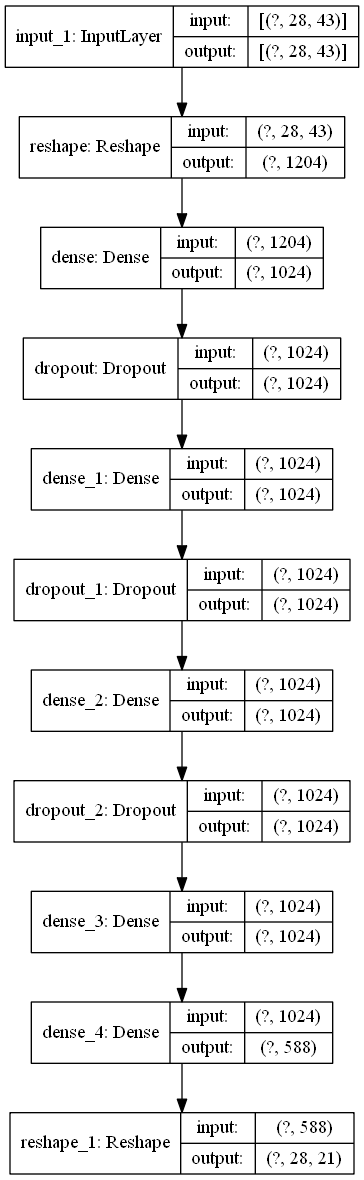

In [ ]:
tf.keras.utils.plot_model(model, to_file='./DNN_{}.png'.format(version), show_shapes=True, show_layer_names=True)

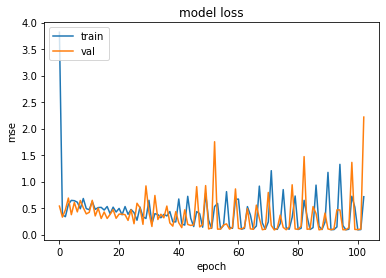

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# 7) Test for Inference Data

In [ ]:
trained_model = load_model('D:/dacon/Vegetable_Price/DNN/save_models/DNN_v1_88_0.08955.h5')

In [ ]:
submission = pd.read_csv('D:/dacon/Vegetable_Price/data/sample_submission.csv')

In [ ]:
public_date_list = submission[submission['예측대상일자'].str.contains('2020')]['예측대상일자'].str.split('+').str[0].unique()

In [ ]:
inference_submission = pd.DataFrame(columns=submission.columns)

In [ ]:
inference_submission['예측대상일자'] = public_date_list.tolist()
inference_submission

,예측대상일자,배추_가격(원/kg),무_가격(원/kg),양파_가격(원/kg),건고추_가격(원/kg),마늘_가격(원/kg),대파_가격(원/kg),얼갈이배추_가격(원/kg),양배추_가격(원/kg),깻잎_가격(원/kg),...,당근_가격(원/kg),파프리카_가격(원/kg),새송이_가격(원/kg),팽이버섯_가격(원/kg),토마토_가격(원/kg),청상추_가격(원/kg),백다다기_가격(원/kg),애호박_가격(원/kg),캠벨얼리_가격(원/kg),샤인마스캇_가격(원/kg)
0,2020-09-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020-09-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2020-10-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2020-10-02,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2020-10-03,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,2020-10-04,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2020-10-05,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2020-10-06,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2020-10-07,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2020-10-08,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
outputs = []
norm_ = norm.to_numpy()[2::2]

for idx, date in tqdm(zip(range(len(public_date_list) - window_size +1), public_date_list)):
    test_df = pd.read_csv(f'D:/dacon/Vegetable_Price/data/public_data/test_files/test_{date}.csv')
    data = pd.read_csv('D:/dacon/Vegetable_Price/data/public_data/train.csv')
    data = pd.concat([data, test_df]).iloc[-window_size:]

    week_day_map = {}
    for i, d in enumerate(data['요일'].unique()):
        week_day_map[d] = i
    data['요일'] = data['요일'].map(week_day_map)
    data = data.iloc[:,1:]/norm

    new_data = tf.reshape(data, [-1, window_size, 43])
    output = trained_model.predict(new_data)*norm_

    inference_submission.loc[idx:idx+window_size-1, '배추_가격(원/kg)':] = output[0]

11it [00:00, 25.35it/s]


In [ ]:
inference_submission

,예측대상일자,배추_가격(원/kg),무_가격(원/kg),양파_가격(원/kg),건고추_가격(원/kg),마늘_가격(원/kg),대파_가격(원/kg),얼갈이배추_가격(원/kg),양배추_가격(원/kg),깻잎_가격(원/kg),...,당근_가격(원/kg),파프리카_가격(원/kg),새송이_가격(원/kg),팽이버섯_가격(원/kg),토마토_가격(원/kg),청상추_가격(원/kg),백다다기_가격(원/kg),애호박_가격(원/kg),캠벨얼리_가격(원/kg),샤인마스캇_가격(원/kg)
0,2020-09-29,1046.876907,947.330146,661.676407,10652.055655,2476.747725,1960.574575,1437.528234,721.58295,6595.010488,...,1260.931827,5077.955612,2755.197525,3441.123621,2860.697198,4537.513315,2502.980883,2628.473913,1899.56706,12714.27989
1,2020-09-30,1379.807442,941.968036,672.414541,12143.808079,2908.428804,2108.006798,1608.44881,721.846973,5929.768183,...,1324.778348,4817.411406,2645.203829,3182.828996,2956.737217,4929.586985,2560.506677,2416.005518,1424.589939,14238.402843
2,2020-10-01,1136.387512,978.654165,535.216093,10059.94781,2599.170289,1894.823698,1285.864433,763.473857,6277.802588,...,1280.18897,5373.335305,2552.174091,3126.111905,2778.71946,4345.201478,2282.418744,2566.530165,2505.475841,12761.795521
3,2020-10-02,1037.880704,948.938909,599.458814,14701.26069,2995.358066,1898.418172,1330.881209,673.207214,6538.560695,...,1240.112633,4651.88719,2441.411495,3124.92947,2685.974546,3566.38368,2031.53743,2188.194001,847.749412,14249.361753
4,2020-10-03,1172.544062,937.881117,656.217456,5668.714963,3202.021492,2094.524107,1411.5571,814.531929,6603.364154,...,1374.573335,4599.976056,2582.484245,3429.769322,2897.604908,4346.314884,2211.388643,2593.215596,2516.216226,12026.722431
5,2020-10-04,772.41987,567.659707,288.217336,5957.397306,900.697306,1314.1579,862.864272,359.196138,2674.393107,...,868.564714,1771.815412,1279.021502,1786.125853,985.079416,2038.327946,930.413333,902.509159,-821.233355,7471.482754
6,2020-10-05,1129.213944,798.695254,637.473702,12786.305888,3135.505868,1555.19087,1424.647248,777.017115,7154.130154,...,1412.231885,5212.943707,2410.772562,3106.395075,2516.322329,4053.344901,2706.759551,2020.468032,3279.640526,13500.788212
7,2020-10-06,909.698084,891.099648,746.27316,15716.978218,3081.919494,1705.377553,1259.414752,877.706496,6227.960243,...,1487.276852,4722.610918,2386.415482,3168.855255,2860.303021,3565.767066,2412.952171,1929.113872,2510.828152,14354.362488
8,2020-10-07,957.390442,891.855068,677.319109,19232.258893,3427.070116,1806.55615,1330.153799,821.345132,5487.398749,...,1410.192624,4459.761938,2403.076172,2706.439013,2780.256095,3080.19067,2205.200451,1939.758067,1715.586148,13776.623011
9,2020-10-08,807.429105,766.039219,475.776672,14463.552539,2528.971546,1484.169761,944.430494,700.427898,4636.552724,...,1182.738394,3877.023727,1990.593672,2413.998834,2372.536254,2080.578426,1660.064628,2055.75988,2910.862677,11468.21022


In [ ]:
inference_submission = inference_submission.rename(columns={'예측대상일자':'date'})
inference_submission

,date,배추_가격(원/kg),무_가격(원/kg),양파_가격(원/kg),건고추_가격(원/kg),마늘_가격(원/kg),대파_가격(원/kg),얼갈이배추_가격(원/kg),양배추_가격(원/kg),깻잎_가격(원/kg),...,당근_가격(원/kg),파프리카_가격(원/kg),새송이_가격(원/kg),팽이버섯_가격(원/kg),토마토_가격(원/kg),청상추_가격(원/kg),백다다기_가격(원/kg),애호박_가격(원/kg),캠벨얼리_가격(원/kg),샤인마스캇_가격(원/kg)
0,2020-09-29,1046.876907,947.330146,661.676407,10652.055655,2476.747725,1960.574575,1437.528234,721.58295,6595.010488,...,1260.931827,5077.955612,2755.197525,3441.123621,2860.697198,4537.513315,2502.980883,2628.473913,1899.56706,12714.27989
1,2020-09-30,1379.807442,941.968036,672.414541,12143.808079,2908.428804,2108.006798,1608.44881,721.846973,5929.768183,...,1324.778348,4817.411406,2645.203829,3182.828996,2956.737217,4929.586985,2560.506677,2416.005518,1424.589939,14238.402843
2,2020-10-01,1136.387512,978.654165,535.216093,10059.94781,2599.170289,1894.823698,1285.864433,763.473857,6277.802588,...,1280.18897,5373.335305,2552.174091,3126.111905,2778.71946,4345.201478,2282.418744,2566.530165,2505.475841,12761.795521
3,2020-10-02,1037.880704,948.938909,599.458814,14701.26069,2995.358066,1898.418172,1330.881209,673.207214,6538.560695,...,1240.112633,4651.88719,2441.411495,3124.92947,2685.974546,3566.38368,2031.53743,2188.194001,847.749412,14249.361753
4,2020-10-03,1172.544062,937.881117,656.217456,5668.714963,3202.021492,2094.524107,1411.5571,814.531929,6603.364154,...,1374.573335,4599.976056,2582.484245,3429.769322,2897.604908,4346.314884,2211.388643,2593.215596,2516.216226,12026.722431
5,2020-10-04,772.41987,567.659707,288.217336,5957.397306,900.697306,1314.1579,862.864272,359.196138,2674.393107,...,868.564714,1771.815412,1279.021502,1786.125853,985.079416,2038.327946,930.413333,902.509159,-821.233355,7471.482754
6,2020-10-05,1129.213944,798.695254,637.473702,12786.305888,3135.505868,1555.19087,1424.647248,777.017115,7154.130154,...,1412.231885,5212.943707,2410.772562,3106.395075,2516.322329,4053.344901,2706.759551,2020.468032,3279.640526,13500.788212
7,2020-10-06,909.698084,891.099648,746.27316,15716.978218,3081.919494,1705.377553,1259.414752,877.706496,6227.960243,...,1487.276852,4722.610918,2386.415482,3168.855255,2860.303021,3565.767066,2412.952171,1929.113872,2510.828152,14354.362488
8,2020-10-07,957.390442,891.855068,677.319109,19232.258893,3427.070116,1806.55615,1330.153799,821.345132,5487.398749,...,1410.192624,4459.761938,2403.076172,2706.439013,2780.256095,3080.19067,2205.200451,1939.758067,1715.586148,13776.623011
9,2020-10-08,807.429105,766.039219,475.776672,14463.552539,2528.971546,1484.169761,944.430494,700.427898,4636.552724,...,1182.738394,3877.023727,1990.593672,2413.998834,2372.536254,2080.578426,1660.064628,2055.75988,2910.862677,11468.21022


In [ ]:
inference_submission_1 = inference_submission.iloc[:-1]
inference_submission_1

,date,배추_가격(원/kg),무_가격(원/kg),양파_가격(원/kg),건고추_가격(원/kg),마늘_가격(원/kg),대파_가격(원/kg),얼갈이배추_가격(원/kg),양배추_가격(원/kg),깻잎_가격(원/kg),...,당근_가격(원/kg),파프리카_가격(원/kg),새송이_가격(원/kg),팽이버섯_가격(원/kg),토마토_가격(원/kg),청상추_가격(원/kg),백다다기_가격(원/kg),애호박_가격(원/kg),캠벨얼리_가격(원/kg),샤인마스캇_가격(원/kg)
0,2020-09-29,1046.876907,947.330146,661.676407,10652.055655,2476.747725,1960.574575,1437.528234,721.58295,6595.010488,...,1260.931827,5077.955612,2755.197525,3441.123621,2860.697198,4537.513315,2502.980883,2628.473913,1899.56706,12714.27989
1,2020-09-30,1379.807442,941.968036,672.414541,12143.808079,2908.428804,2108.006798,1608.44881,721.846973,5929.768183,...,1324.778348,4817.411406,2645.203829,3182.828996,2956.737217,4929.586985,2560.506677,2416.005518,1424.589939,14238.402843
2,2020-10-01,1136.387512,978.654165,535.216093,10059.94781,2599.170289,1894.823698,1285.864433,763.473857,6277.802588,...,1280.18897,5373.335305,2552.174091,3126.111905,2778.71946,4345.201478,2282.418744,2566.530165,2505.475841,12761.795521
3,2020-10-02,1037.880704,948.938909,599.458814,14701.26069,2995.358066,1898.418172,1330.881209,673.207214,6538.560695,...,1240.112633,4651.88719,2441.411495,3124.92947,2685.974546,3566.38368,2031.53743,2188.194001,847.749412,14249.361753
4,2020-10-03,1172.544062,937.881117,656.217456,5668.714963,3202.021492,2094.524107,1411.5571,814.531929,6603.364154,...,1374.573335,4599.976056,2582.484245,3429.769322,2897.604908,4346.314884,2211.388643,2593.215596,2516.216226,12026.722431
5,2020-10-04,772.41987,567.659707,288.217336,5957.397306,900.697306,1314.1579,862.864272,359.196138,2674.393107,...,868.564714,1771.815412,1279.021502,1786.125853,985.079416,2038.327946,930.413333,902.509159,-821.233355,7471.482754
6,2020-10-05,1129.213944,798.695254,637.473702,12786.305888,3135.505868,1555.19087,1424.647248,777.017115,7154.130154,...,1412.231885,5212.943707,2410.772562,3106.395075,2516.322329,4053.344901,2706.759551,2020.468032,3279.640526,13500.788212
7,2020-10-06,909.698084,891.099648,746.27316,15716.978218,3081.919494,1705.377553,1259.414752,877.706496,6227.960243,...,1487.276852,4722.610918,2386.415482,3168.855255,2860.303021,3565.767066,2412.952171,1929.113872,2510.828152,14354.362488
8,2020-10-07,957.390442,891.855068,677.319109,19232.258893,3427.070116,1806.55615,1330.153799,821.345132,5487.398749,...,1410.192624,4459.761938,2403.076172,2706.439013,2780.256095,3080.19067,2205.200451,1939.758067,1715.586148,13776.623011
9,2020-10-08,807.429105,766.039219,475.776672,14463.552539,2528.971546,1484.169761,944.430494,700.427898,4636.552724,...,1182.738394,3877.023727,1990.593672,2413.998834,2372.536254,2080.578426,1660.064628,2055.75988,2910.862677,11468.21022


In [ ]:
inference_submission_2 = inference_submission_1.copy()

for col in inference_submission_2.columns[1:]:
    inference_submission_2[col] = inference_submission_2[col].apply(lambda x : 0 if x <= 0 else x)

inference_submission_2

,date,배추_가격(원/kg),무_가격(원/kg),양파_가격(원/kg),건고추_가격(원/kg),마늘_가격(원/kg),대파_가격(원/kg),얼갈이배추_가격(원/kg),양배추_가격(원/kg),깻잎_가격(원/kg),...,당근_가격(원/kg),파프리카_가격(원/kg),새송이_가격(원/kg),팽이버섯_가격(원/kg),토마토_가격(원/kg),청상추_가격(원/kg),백다다기_가격(원/kg),애호박_가격(원/kg),캠벨얼리_가격(원/kg),샤인마스캇_가격(원/kg)
0,2020-09-29,1046.876907,947.330146,661.676407,10652.055655,2476.747725,1960.574575,1437.528234,721.582950,6595.010488,...,1260.931827,5077.955612,2755.197525,3441.123621,2860.697198,4537.513315,2502.980883,2628.473913,1899.567060,12714.279890
1,2020-09-30,1379.807442,941.968036,672.414541,12143.808079,2908.428804,2108.006798,1608.448810,721.846973,5929.768183,...,1324.778348,4817.411406,2645.203829,3182.828996,2956.737217,4929.586985,2560.506677,2416.005518,1424.589939,14238.402843
2,2020-10-01,1136.387512,978.654165,535.216093,10059.947810,2599.170289,1894.823698,1285.864433,763.473857,6277.802588,...,1280.188970,5373.335305,2552.174091,3126.111905,2778.719460,4345.201478,2282.418744,2566.530165,2505.475841,12761.795521
3,2020-10-02,1037.880704,948.938909,599.458814,14701.260690,2995.358066,1898.418172,1330.881209,673.207214,6538.560695,...,1240.112633,4651.887190,2441.411495,3124.929470,2685.974546,3566.383680,2031.537430,2188.194001,847.749412,14249.361753
4,2020-10-03,1172.544062,937.881117,656.217456,5668.714963,3202.021492,2094.524107,1411.557100,814.531929,6603.364154,...,1374.573335,4599.976056,2582.484245,3429.769322,2897.604908,4346.314884,2211.388643,2593.215596,2516.216226,12026.722431
5,2020-10-04,772.419870,567.659707,288.217336,5957.397306,900.697306,1314.157900,862.864272,359.196138,2674.393107,...,868.564714,1771.815412,1279.021502,1786.125853,985.079416,2038.327946,930.413333,902.509159,0.000000,7471.482754
6,2020-10-05,1129.213944,798.695254,637.473702,12786.305888,3135.505868,1555.190870,1424.647248,777.017115,7154.130154,...,1412.231885,5212.943707,2410.772562,3106.395075,2516.322329,4053.344901,2706.759551,2020.468032,3279.640526,13500.788212
7,2020-10-06,909.698084,891.099648,746.273160,15716.978218,3081.919494,1705.377553,1259.414752,877.706496,6227.960243,...,1487.276852,4722.610918,2386.415482,3168.855255,2860.303021,3565.767066,2412.952171,1929.113872,2510.828152,14354.362488
8,2020-10-07,957.390442,891.855068,677.319109,19232.258893,3427.070116,1806.556150,1330.153799,821.345132,5487.398749,...,1410.192624,4459.761938,2403.076172,2706.439013,2780.256095,3080.190670,2205.200451,1939.758067,1715.586148,13776.623011
9,2020-10-08,807.429105,766.039219,475.776672,14463.552539,2528.971546,1484.169761,944.430494,700.427898,4636.552724,...,1182.738394,3877.023727,1990.593672,2413.998834,2372.536254,2080.578426,1660.064628,2055.759880,2910.862677,11468.210220


In [ ]:
test_df = pd.read_csv(f'D:/dacon/Vegetable_Price/data/public_data/test_files/test_{"2020-11-05"}.csv')
test_df

,date,요일,배추_거래량(kg),배추_가격(원/kg),무_거래량(kg),무_가격(원/kg),양파_거래량(kg),양파_가격(원/kg),건고추_거래량(kg),건고추_가격(원/kg),...,청상추_거래량(kg),청상추_가격(원/kg),백다다기_거래량(kg),백다다기_가격(원/kg),애호박_거래량(kg),애호박_가격(원/kg),캠벨얼리_거래량(kg),캠벨얼리_가격(원/kg),샤인마스캇_거래량(kg),샤인마스캇_가격(원/kg)
0,2020-09-29,화요일,2064183.3,1787.0,2424383.2,1190.0,1209647.0,966.0,2842.8,25873.0,...,76702.8,3678.0,375798.6,2794.0,450576.5,2350.0,495845.2,3937.0,259765.0,11400.0
1,2020-09-30,수요일,259065.3,1551.0,1044460.0,984.0,136696.4,857.0,35.0,9929.0,...,53183.2,1892.0,387513.8,1858.0,386869.7,1311.0,263761.0,3885.0,121859.6,11649.0
2,2020-10-01,목요일,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2020-10-02,금요일,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2020-10-03,토요일,0.0,0.0,3100.0,835.0,0.0,0.0,0.0,0.0,...,724.0,2186.0,0.0,0.0,2552.0,1243.0,0.0,0.0,0.0,0.0
5,2020-10-04,일요일,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,2020-10-05,월요일,1965239.2,1483.0,2041917.7,1043.0,1733549.9,1002.0,487.8,23450.0,...,115472.0,1551.0,1207386.1,1027.0,1093237.6,878.0,294465.0,3895.0,192707.1,11803.0
7,2020-10-06,화요일,1784379.1,1359.0,2064575.9,996.0,1611985.7,1095.0,1070.1,16165.0,...,70574.0,1367.0,540580.1,1339.0,454010.8,1112.0,263117.8,3707.0,183881.3,11159.0
8,2020-10-07,수요일,1672867.3,1316.0,2125164.2,901.0,1873624.8,1122.0,1415.6,14654.0,...,57944.0,1355.0,458706.5,1367.0,468148.3,1222.0,263120.0,3407.0,206705.9,10619.0
9,2020-10-08,목요일,1588132.2,1159.0,1780584.9,879.0,1885755.5,1142.0,2361.0,15138.0,...,45074.0,1459.0,429872.0,1261.0,444752.2,1152.0,247170.0,3224.0,202764.1,9873.0


In [ ]:
test_df_1 = test_df.loc[:, '배추_가격(원/kg)'::2]
test_df_1 = pd.concat([test_df['date'], test_df_1], axis=1)
test_df_1

,date,배추_가격(원/kg),무_가격(원/kg),양파_가격(원/kg),건고추_가격(원/kg),마늘_가격(원/kg),대파_가격(원/kg),얼갈이배추_가격(원/kg),양배추_가격(원/kg),깻잎_가격(원/kg),...,당근_가격(원/kg),파프리카_가격(원/kg),새송이_가격(원/kg),팽이버섯_가격(원/kg),토마토_가격(원/kg),청상추_가격(원/kg),백다다기_가격(원/kg),애호박_가격(원/kg),캠벨얼리_가격(원/kg),샤인마스캇_가격(원/kg)
0,2020-09-29,1787.0,1190.0,966.0,25873.0,5404.0,2682.0,2460.0,1584.0,11298.0,...,1743.0,7579.0,3343.0,3102.0,4268.0,3678.0,2794.0,2350.0,3937.0,11400.0
1,2020-09-30,1551.0,984.0,857.0,9929.0,5575.0,2774.0,1513.0,1379.0,6476.0,...,956.0,4770.0,2561.0,2400.0,3550.0,1892.0,1858.0,1311.0,3885.0,11649.0
2,2020-10-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2020-10-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2020-10-03,0.0,835.0,0.0,0.0,0.0,3784.0,0.0,0.0,5091.0,...,0.0,0.0,0.0,0.0,3437.0,2186.0,0.0,1243.0,0.0,0.0
5,2020-10-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,2020-10-05,1483.0,1043.0,1002.0,23450.0,5683.0,2427.0,1201.0,1653.0,4142.0,...,1665.0,5277.0,2606.0,3156.0,3083.0,1551.0,1027.0,878.0,3895.0,11803.0
7,2020-10-06,1359.0,996.0,1095.0,16165.0,5235.0,2582.0,1204.0,1386.0,3696.0,...,1743.0,4919.0,2554.0,2978.0,3358.0,1367.0,1339.0,1112.0,3707.0,11159.0
8,2020-10-07,1316.0,901.0,1122.0,14654.0,5292.0,2768.0,1138.0,1405.0,3784.0,...,1709.0,5465.0,2556.0,2181.0,3538.0,1355.0,1367.0,1222.0,3407.0,10619.0
9,2020-10-08,1159.0,879.0,1142.0,15138.0,5102.0,2659.0,1086.0,1486.0,3927.0,...,1568.0,4743.0,2498.0,1770.0,3765.0,1459.0,1261.0,1152.0,3224.0,9873.0


In [ ]:
def nmae(answer_df, submission_df):
    answer = answer_df.iloc[:,1:].to_numpy()
    submission = submission_df.iloc[:,1:].to_numpy()
    target_idx = np.where(answer!=0)

    true = answer[target_idx]
    pred = submission[target_idx]

    score = np.mean(np.abs(true-pred)/true)

    return score


def at_nmae(answer_df, submission_df):
    week_1_answer = answer_df.iloc[0::3]
    week_2_answer = answer_df.iloc[1::3]
    week_4_answer = answer_df.iloc[2::3]

    idx_col_nm = answer_df.columns[0]
    week_1_submission = submission_df[submission_df[idx_col_nm].isin(week_1_answer[idx_col_nm])]
    week_2_submission = submission_df[submission_df[idx_col_nm].isin(week_2_answer[idx_col_nm])]
    week_4_submission = submission_df[submission_df[idx_col_nm].isin(week_4_answer[idx_col_nm])]

    score1 = nmae(week_1_answer, week_1_submission)
    score2 = nmae(week_2_answer, week_2_submission)
    score4 = nmae(week_4_answer, week_4_submission)

    score = (score1+score2+score4)/3

    return score

In [ ]:
at_nmae(test_df_1, inference_submission_2)

0.3757539706634884

# 8) Test for Private Data

In [ ]:
private_df = pd.read_csv("D:/dacon/Vegetable_Price/data/private_data/private_data.csv")
private_df

In [ ]:
private_submission = pd.concat([private_df['date'], private_df.loc[:, '배추_가격(원/kg)'::2]], axis=1)
private_submission

In [ ]:
test_inference_merge_df = pd.concat([test_df_1, inference_submission.iloc[-1:]], axis=0)
test_inference_merge_df

In [ ]:
test_df

In [ ]:
test_inference_merge_df['요일'] = test_df['요일']
test_inference_merge_df['요일'].iloc[-1] = '목요일'
test_inference_merge_df

In [ ]:
test_inference_merge_df = test_inference_merge_df[['date', '요일', '배추_가격(원/kg)', '무_가격(원/kg)', '양파_가격(원/kg)', '건고추_가격(원/kg)',
       '마늘_가격(원/kg)', '대파_가격(원/kg)', '얼갈이배추_가격(원/kg)', '양배추_가격(원/kg)',
       '깻잎_가격(원/kg)', '시금치_가격(원/kg)', '미나리_가격(원/kg)', '당근_가격(원/kg)',
       '파프리카_가격(원/kg)', '새송이_가격(원/kg)', '팽이버섯_가격(원/kg)', '토마토_가격(원/kg)',
       '청상추_가격(원/kg)', '백다다기_가격(원/kg)', '애호박_가격(원/kg)', '캠벨얼리_가격(원/kg)',
       '샤인마스캇_가격(원/kg)']]
test_inference_merge_df

In [ ]:
outputs = []
norm_ = norm.to_numpy()[2::2]

for idx, date in tqdm(zip(range(len(public_date_list) - window_size), list(private_df['date']))):
    if idx == 0:
        test_df = pd.read_csv(f'D:/dacon/Vegetable_Price/data/public_data/test_files/test_{"2020-09-29"}.csv')
        data = pd.concat([test_inference_merge_df, test_df]).iloc[-window_size:]

    else:
        test_df = private_df[private_df['date'] == date]
        data = pd.concat([test_inference_merge_df, test_df]).iloc[-window_size:]

    week_day_map = {}
    for i, d in enumerate(data['요일'].unique()):
        week_day_map[d] = i
    data['요일'] = data['요일'].map(week_day_map)
    data = data.iloc[:,1:]/norm

    new_data = tf.reshape(data, [-1, window_size, 43])
    output = trained_model.predict(new_data)*norm_

    private_submission.loc[idx:idx+window_size, '배추_가격(원/kg)':] = output[0]

In [ ]:
test_df

In [ ]:
new_data

In [ ]:
private_submission

# 9) Inference to Submission

In [ ]:
outputs = []
norm_ = norm.to_numpy()[2::2]

for date in tqdm(public_date_list):
    test_df = pd.read_csv(f'D:/dacon/Vegetable_Price/data/public_data/test_files/test_{date}.csv')
    data = pd.read_csv('D:/dacon/Vegetable_Price/data/public_data/train.csv')
    data = pd.concat([data, test_df]).iloc[-window_size:]

    week_day_map = {}
    for i, d in enumerate(data['요일'].unique()):
        week_day_map[d] = i
    data['요일'] = data['요일'].map(week_day_map)
    data = data.iloc[:,1:]/norm

    new_data = tf.reshape(data, [-1, window_size, (target_n*2)+1])
    output = trained_model.predict(new_data)*norm_

    idx = submission[submission['예측대상일자'].str.contains(date)].index
    submission.loc[idx, '배추_가격(원/kg)':] = output[0,[6,13,27]]

100%|██████████████████████████████████████████████████████████████████████████████████| 38/38 [00:01<00:00, 24.38it/s]


In [ ]:
submission.to_csv('D:/dacon/Vegetable_Price/DNN/submission/DNN_{}.csv'.format(version), index=False)